# Using an external optimizer
Hazel comes with a preconfigured efficient Levenberg-Marquard algorithm, but it can also use any external optimizer. It can seamlessly integrate all SciPy optimizers but it also provides the tools to use other optimizers.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
from scipy.optimize import minimize, differential_evolution
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

/scratch/Dropbox/GIT/hazel2/hazel/io.py:12: UserWarning: zarr module not found. You will not be able to use zarr as input/output.
  warnings.warn("zarr module not found. You will not be able to use zarr as input/output.")


2018.06.07


Let's start by generating a model by reading the following configuration file:

In [2]:
%cat conf_single.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 1

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Wavelength = 10826, 10833, 150
    Topology = ph1 -> ch1 -> te1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = 'observations/10830.wavelength'
    Wavelength weight file = 'observations/10830.weights'
    Observations file = 'observations/10830_stokes.1d'    
    Weights Stokes I = 1.0, 0.0, 0.0, 0.0
    Weights Stokes Q = 0.0, 0.0, 0.0, 0.0
    Weights Stokes U = 0.0, 0.0, 0.0, 0.0
    Weights Stokes V = 0.0, 0.0, 0.0, 0.0
    Mask

This is a very simple inversion in which only two variables are inverted. This is surely not realistic but serves for the purpose of showing how more complicated things can be done. Let's then read the configuration file and read the observation file defined in the configuration file.

In [3]:
# Test a single inversion in non-iterator mode
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()

2018-10-05 13:15:01,845 - Adding spectral region spec1
2018-10-05 13:15:01,846 -   - Reading wavelength axis from observations/10830.wavelength
2018-10-05 13:15:01,849 -   - Reading wavelength weights from observations/10830.weights
2018-10-05 13:15:01,853 -   - Using observations from observations/10830_stokes.1d
2018-10-05 13:15:01,854 -   - No mask for pixels
2018-10-05 13:15:01,856 -   - No instrumental profile
2018-10-05 13:15:01,859 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-05 13:15:01,863 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-05 13:15:01,867 - Using 1 cycles
2018-10-05 13:15:01,869 - Not using randomizations
2018-10-05 13:15:01,872 - Adding atmospheres
2018-10-05 13:15:01,873 -   - New available photosphere : ph1
2018-10-05 13:15:01,875 -     * Adding line : [300]
2018-10-05 13:15:01,877 -     * Magnetic field reference frame : vertical
2018-10-05 13:15:01,878 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-10-0

Next, let us invert it with the Levenberg-Marquartd algorithm provided by Hazel:

In [4]:
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-05 13:15:04,949 - -------------
2018-10-05 13:15:04,950 -   Cycle 0  
2018-10-05 13:15:04,952 -   Weights for region spec1 : SI=1.0 - SQ=0.0 - SU=0.0 - SV=0.0
2018-10-05 13:15:04,953 - -------------
2018-10-05 13:15:04,955 - Free parameters for ph1
2018-10-05 13:15:04,957 -   - T with 1 node
2018-10-05 13:15:04,959 -   - vmic with 1 node
2018-10-05 13:15:05,270 - It: 0 - chi2: 111.73491265894616 - lambda: 0.01827468471342611 - rel: -1.9999999553060352
2018-10-05 13:15:05,437 - It: 1 - chi2: 94.9879533212469 - lambda: 0.004287504963923828 - rel: -0.1620232890860157
2018-10-05 13:15:05,540 - It: 2 - chi2: 94.9844932019989 - lambda: 0.09602514964800882 - rel: -3.642759054093184e-05


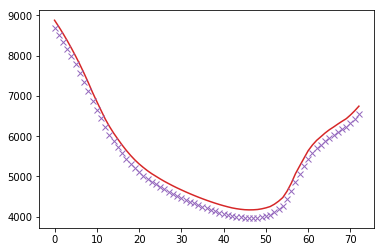

In [5]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

### Using SciPy

Then we open the output file, call `invert_external`, write the output and close it. `invert_external` allows the user to pass an SciPy optimizer and the arguments for the optimizer. The advantage of the SciPy optimizers is that they share the arguments. In this example, we'll use the Nelder-Mead algorithm, that does not use derivatives.

In [6]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert_external(minimize, method='Nelder-Mead')
mod.write_output()
mod.close_output()

2018-10-05 13:15:12,059 - Adding spectral region spec1
2018-10-05 13:15:12,060 -   - Reading wavelength axis from observations/10830.wavelength
2018-10-05 13:15:12,063 -   - Reading wavelength weights from observations/10830.weights
2018-10-05 13:15:12,069 -   - Using observations from observations/10830_stokes.1d
2018-10-05 13:15:12,072 -   - No mask for pixels
2018-10-05 13:15:12,075 -   - No instrumental profile
2018-10-05 13:15:12,076 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-05 13:15:12,077 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-05 13:15:12,079 - Using 1 cycles
2018-10-05 13:15:12,080 - Not using randomizations
2018-10-05 13:15:12,081 - Adding atmospheres
2018-10-05 13:15:12,082 -   - New available photosphere : ph1
2018-10-05 13:15:12,083 -     * Adding line : [300]
2018-10-05 13:15:12,084 -     * Magnetic field reference frame : vertical
2018-10-05 13:15:12,086 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-10-0

AttributeError: 'Model' object has no attribute 'n_free_parameters_cycle'

Now we plot the results.

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


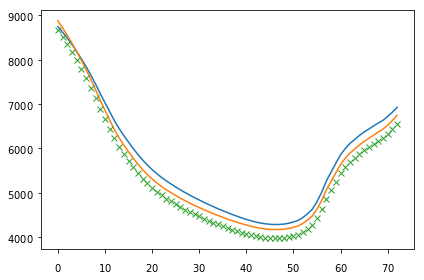

In [16]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

Now let's use an optimizer that uses first-order derivatives. Let's select the Newton-CG method:

In [17]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert_external(minimize, use_jacobian=True, method='Newton-CG')
mod.write_output()
mod.close_output()

2018-07-10 16:50:45,019 - Adding spectral region spec1
2018-07-10 16:50:45,021 -   - Reading wavelength axis from observations/10830.wavelength
2018-07-10 16:50:45,027 -   - Reading wavelength weights from observations/10830.weights
2018-07-10 16:50:45,034 -   - Using observations from observations/10830_stokes.1d
2018-07-10 16:50:45,036 -   - No mask for pixels
2018-07-10 16:50:45,038 -   - Using LOS ['0.0', '0.0', '90.0']
2018-07-10 16:50:45,039 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-07-10 16:50:45,041 - Using 1 cycles
2018-07-10 16:50:45,043 - Adding atmospheres
2018-07-10 16:50:45,045 -   - New available photosphere : ph1
2018-07-10 16:50:45,046 -     * Adding line : [300]
2018-07-10 16:50:45,048 -     * Magnetic field reference frame : vertical
2018-07-10 16:50:45,050 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-07-10 16:50:45,057 -   - New available chromosphere : ch1
2018-07-10 16:50:45,059 -     * Adding line : 10830

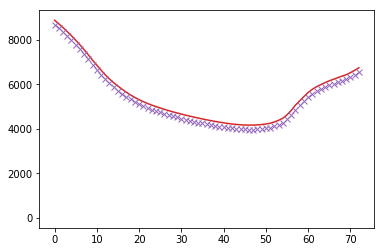

In [7]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

### Using other external optimizers (pro-mode)
Using non-SciPy optimizers is slightly more complicated. For this purpose Hazel provides the necessary tools to use them. Here we show an example using the well-known Adam optimizer, broadly used for training deep neural networks. It is a first-order optimizer which uses derivative information. Let us first define a class that implements the Adam optimizer:

In [8]:
class AdamOptimizer:
    def __init__(self, fun, x0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0
        self.theta = x0
        self.fun = fun

    def optimize(self, n_iter):
        for i in range(n_iter):
            f, gradient = self.fun(self.theta)
            self.t = self.t + 1
            self.m = self.beta1*self.m + (1 - self.beta1)*gradient
            self.v = self.beta2*self.v + (1 - self.beta2)*(gradient**2)
            m_hat = self.m/(1 - self.beta1**self.t)
            v_hat = self.v/(1 - self.beta2**self.t)
            self.theta = self.theta - self.alpha*(m_hat/(np.sqrt(v_hat) - self.epsilon))
            print("Iter: {0} - chi2: {1}".format(self.t, f))
        return self.theta

Now we instantiate the model, read the observations and open the output. Next, we need to follow what `invert_external` does. First, compute some factors used internally by Hazel. Loop over all cycles with the following steps: i) find the active parameters, ii) instantiate the optimizer with the `_func_grad` function provided by Hazel, iii) call the optimizer, iv) set the final model and v) propagate the new parameters to the final ones. Finally, we write the output.

In [9]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()

for k, v in mod.spectrum.items():
    v.factor_chi2 = 1.0 / (v.noise**2 * v.dof)

for mod.cycle in range(mod.n_cycles):
    mod.find_active_parameters(mod.cycle)
    n_pars = len(mod.nodes)
    
    optimizer = AdamOptimizer(mod._func_grad, mod.nodes)
    
    tmp = optimizer.optimize(300)
    
    mod.set_new_model(tmp)

    mod.flatten_parameters_to_reference(mod.cycle)
    
mod.write_output()
mod.close_output()

2018-10-05 13:15:27,266 - Adding spectral region spec1
2018-10-05 13:15:27,268 -   - Reading wavelength axis from observations/10830.wavelength
2018-10-05 13:15:27,271 -   - Reading wavelength weights from observations/10830.weights
2018-10-05 13:15:27,275 -   - Using observations from observations/10830_stokes.1d
2018-10-05 13:15:27,277 -   - No mask for pixels
2018-10-05 13:15:27,279 -   - No instrumental profile
2018-10-05 13:15:27,280 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-05 13:15:27,282 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-05 13:15:27,283 - Using 1 cycles
2018-10-05 13:15:27,285 - Not using randomizations
2018-10-05 13:15:27,290 - Adding atmospheres
2018-10-05 13:15:27,292 -   - New available photosphere : ph1
2018-10-05 13:15:27,294 -     * Adding line : [300]
2018-10-05 13:15:27,296 -     * Magnetic field reference frame : vertical
2018-10-05 13:15:27,301 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-10-0

OSError: Unable to create file (unable to truncate a file which is already open)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


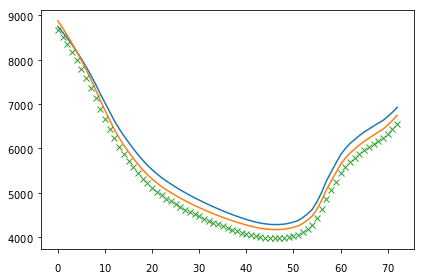

In [4]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()